In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

Training a Classifier
=====================

We will use the MNIST dataset.

Training an image classifier
----------------------------

We will do the following steps in order:

1.  Load and normalize the training and test datasets
2.  Define a Convolutional Neural Network
3.  Define a loss function
4.  Train the network on the training data
5.  Test the network on the test data

### 1. Load and normalize the dataset


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range \[0,
1\]. We transform them to Tensors of normalized range \[-1, 1\].


In [14]:
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# batch_size = 4

# trainset = torchvision.datasets.MNIST(root='./data', train=True,
#                                         download=True, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
#                                           shuffle=True, num_workers=2)

# testset = torchvision.datasets.MNIST(root='./data', train=False,
#                                        download=True, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
#                                          shuffle=False, num_workers=2)
# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# classes = tuple(str(i) for i in range(10))
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))])  # MNIST mean and std

batch_size = 64   # You can choose 4 or bigger, 64 is common

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = tuple(str(i) for i in range(10))

Let us show some of the training images, for fun.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.28789353..1.9107434].


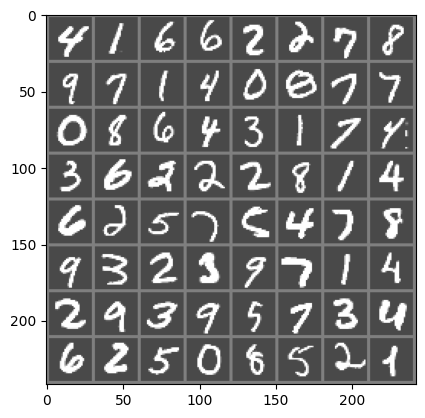

4     1     6     6     2     2     7     8     9     7     1     4     0     8     7     7     0     8     6     4     3     1     7     4     3     6     2     2     2     8     1     4     6     2     5     7     5     4     7     8     9     3     2     3     9     7     1     4     2     9     3     9     5     7     3     4     6     2     5     0     8     5     2     1    


In [15]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

2. Define a Convolutional Neural Network
========================================



In [17]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)           # 1 channel for MNIST
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)      # 28x28 -> conv1(5x5)->24x24->pool->12x12->conv2(5x5)->8x8->pool->4x4
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

3. Define a Loss function and optimizer
=======================================

Let\'s use a Classification Cross-Entropy loss and SGD with momentum.


In [18]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

4. Train the network
====================

This is when things start to get interesting. We simply have to loop
over our data iterator, and feed the inputs to the network and optimize.


In [26]:
for epoch in range(3):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

Finished Training


Let\'s quickly save our trained model:


In [27]:
PATH = './mnist_net.pth'
torch.save(net.state_dict(), PATH)

See [here](https://pytorch.org/docs/stable/notes/serialization.html) for
more details on saving PyTorch models.

5. Test the network on the test data
====================================

We have trained the network over the training dataset.

We will predict the class label that the neural network outputs, and check it against the ground-truth.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.28789353..1.9107434].


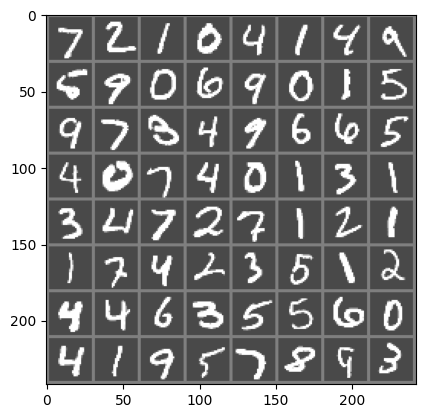

GroundTruth:  7     2     1     0    


In [28]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Next, let\'s load back in our saved model (note: saving and re-loading
the model wasn\'t necessary here, we only did it to illustrate how to do
so):


In [29]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above
are:


In [30]:
outputs = net(images)

The outputs are energies for the 10 classes. The higher the energy for a
class, the more the network thinks that the image is of the particular
class. So, let\'s get the index of the highest energy:


In [31]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  7     2     1     0    


Let us look at how the network performs on the whole dataset.


In [32]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 97 %


That looks way better than chance, which is 10% accuracy (randomly
picking a class out of 10 classes). Seems like the network learnt
something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:


In [33]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: 0     is 99.4 %
Accuracy for class: 1     is 99.2 %
Accuracy for class: 2     is 96.5 %
Accuracy for class: 3     is 96.2 %
Accuracy for class: 4     is 99.4 %
Accuracy for class: 5     is 98.1 %
Accuracy for class: 6     is 98.9 %
Accuracy for class: 7     is 96.5 %
Accuracy for class: 8     is 97.4 %
Accuracy for class: 9     is 95.5 %
